# Bayesian Flow Tutorial: Part 2:<br/>Posterior, Extension, Evaluation

In [130]:
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import jax
import numpy
import scipy
import time

## Problem: Estimating success probability of a robot

Robot Alice can perform one action $A=\{a\}$ and can pass between three states $S=\{s_{start}, s_{success}, s_{failure}\}$. When the action is performed in state $s_{start}$, the robot passes to either $s_{success}$ or $s_{failure}$, in other states, the action has no effect.  We believe that there is a fixed probability $p$ with which the robot passes from $s_{start}$ to $_{success}$. In order to operate the robot, we want to estimate $p$.

We operated the robot several times in state $s_{start}$, letting him to perform $a$, and got the following _sequence_ of outcomes: $[s_{success}, s_{failure}, s_{success}, s_{success}, s_{failure}, s_{success}, s_{success}, s_{success}, s_{failure}, s_{failure}]$. What can we say about $p$?

Let's formalize. We have a vector $\pmb{o}$ of observations (1 - success, 0 - failure)

In [131]:
OBSERVATIONS = [1, 1, 1, 0, 0, 1, 1, 1, 0, 0]

and a latent variable $p$  which affects the observations we get. We assume that observations are random, and we might have gotten a different sequence of successes and failures if we repeated the experiment. 

Looking at this the other way around, even if we new the 'true' $p$, we might get the _same_ observations for _different_ 'true' values of $p$, by chance. This means that we cannot be absolutely certain about the value of $p$ given a finite set of observations.

So, the question is: _What is our belief about $p$ given the observations?_

## Generative modelling with NumPyro

[NumPyro](https://num.pyro.ai) is a library for generative modelling and inference in Python. It is a handy tool to solve problems like ours, and works well with hundreds of latent variables (like our $p$) and elaborated generative models. 

### Generative model

First thing NumPyro provides is a [DSL](https://en.wikipedia.org/wiki/Domain-specific_language) for specifying generative models. Instead of writing the likelihood function, we can just re-write the statistical definition of the model, only in Python.

In [132]:
def robot(obs=None, nobs=len(OBSERVATIONS)):
    """Robot model with NumPyro.
    """
    if obs is not None:  # for prior predictivei
        nobs = len(obs)
    # p ~ Beta(1, 1)
    p = numpyro.sample("p", dist.Beta(1, 1))
    with numpyro.plate("obs", len(obs) if obs is not None else nobs):
        # o ~ Bernoulli(p)
        numpyro.sample("o", dist.Bernoulli(p), obs=obs)

### Prior predictive

The first step we want to perform with any model is to examine its prior predictive, that is, the kind of observations this model is in general able to 'imagine'. NumPyro provides class `Predictive` for this purpose.

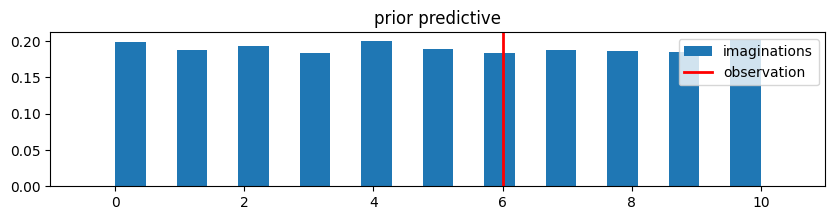

In [133]:
prior_predictive = numpyro.infer.Predictive(robot, num_samples=10000)
prior_samples = prior_predictive(jax.random.PRNGKey(int(time.time() * 1E6)))

plt.figure(figsize=(10, 2))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(o) for o in prior_samples['o']], density=True, bins=len(OBSERVATIONS)*2+1, label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("prior predictive")
plt.legend()
_=_

The above plot of prior predictive helps us analyse our model even before we performed any inference. The actual observation (number of successes out number of trials) is _well covered by the prior_. This means that, given this observation, the model will be able to infer the posterior reasonably efficiently. If, for example, the prior mass on the actual observation were very small, such as if the prior were $\mathrm{Beta(1, 10)}$, our model would be _misspecified_, and the inference would not work well.

### Inference

NumPyro supplies efficient MCMC inference algorithms. A default choice is called [NUTS](https://arxiv.org/abs/1111.4246).  NumPyro's NUTS is both much faster and much better converging inference algorithm than the naive version of MCMC we wrote earlier.

In [184]:
nuts_kernel = numpyro.infer.NUTS(robot)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)

mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=jax.numpy.array(OBSERVATIONS))

/var/folders/c1/rwhzmyd525n89mwj4hk9qn_c0000gn/T/ipykernel_22624/396090589.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|███████████████████████████| 5500/5500 [00:00<00:00, 14646.48it/s, 1 steps of size 8.76e-01. acc. prob=0.94]


When the algorithm finished running, the first thing we want to check is whether the inference results are informative. For this purpose, we 

1. Run several (4) Monte Carlo chains.
2. Print and review summary statistics of the samples in the chains.

In [135]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.58      0.14      0.59      0.35      0.80   6201.01      1.00

Number of divergences: 0


### Posterior

A key outcome of the inference is the posterior distribution of $p$. 

In [348]:
plt.figure(figsize=(5, 2))
plt.title("posterior")
plt.xlabel("p")
plt.hist(mcmc.get_samples()['p'], density=True, bins="auto", label="approximate")
_=__=_

###  Posterior predictive

We generate the posterior predictive using the same tool as we used for prior predictive, only instead of sampling $p$ from the prior we use the posterior samples of $p$. Technically, this is achieved by passing `posterior_samples` to `Predictive`.

In [137]:
posterior_predictive = numpyro.infer.Predictive(robot, posterior_samples=mcmc.get_samples())
posterior_samples = posterior_predictive(jax.random.PRNGKey(int(time.time() * 1E6)))

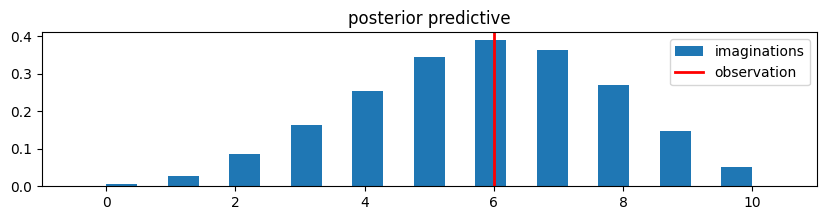

In [138]:
plt.figure(figsize=(10, 2))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(o) for o in posterior_samples['o']], density=True, bins=len(OBSERVATIONS)*2+1, label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("posterior predictive")
plt.legend()
_=_

The above plot looks fine: the imaginations are concentrated around the observation, with  the maximum mass near the observation. We can formalize this by computing the ‘p-value’ of the observation given the predictive posterior, that is, the probability that an imagined observation is greater (or smaller) than the actual one:

In [139]:
p_value = sum(posterior_samples['o'].sum(axis=1) >= sum(OBSERVATIONS))/len(posterior_samples['o'])
print(f"p_value = {p_value:.3f}")

p_value = 0.581


Depending on how strong the prior and how much data we have, p_value between 0.3 and 0.7 is an indication that our posterior is fine. Extreme values, like 0.1 or 0.9 or more extreme, point at a problem in the model.

## Summarizing the posterior

In [140]:
p = mcmc.get_samples()["p"]

### Laplace's approximation 

[Laplace's approximation](https://en.wikipedia.org/wiki/Laplace%27s_approximation) approximates the posterior by a normal distribution. This is what we do when we specify the mean and the standard deviation.

In [141]:
p_mean = p.mean()
p_stddev = p.std()

In [347]:
plt.figure(figsize=(5, 2))
plt.title("posterior")
plt.xlabel("p")
plt.hist(mcmc.get_samples()['p'], density=True, bins="auto", label="approximate")
plt.hist(scipy.stats.norm(p_mean, p_stddev).rvs(100000), bins="auto", histtype="step", density=True, label="Laplace")
plt.legend()
_=__=_

### Summary statistics

In [143]:
quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
pq = numpy.quantile(p, quantiles)
print(f"stat\tp\n-------------")
print(f"mean\t{p_mean:.3f}")
print(f"stddev\t{p_stddev:.3f}")
for i in range(len(quantiles)):
    print(f"{quantiles[i]*100:3.0f}%\t{pq[i]:.3f}") 


stat	p
-------------
mean	0.584
stddev	0.137
  0%	0.125
  2%	0.310
 25%	0.490
 50%	0.588
 75%	0.683
 98%	0.833
100%	0.966


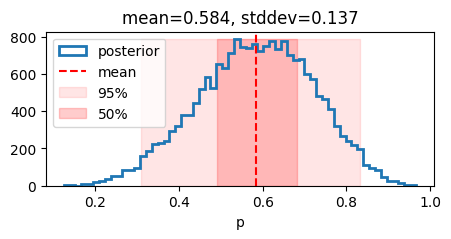

In [145]:
plt.figure(figsize=(5, 2))
plt.xlabel("p")
height, _, _ = plt.hist(p, histtype="step", lw=2, bins="auto", label="posterior")
plt.title(f"mean={p_mean:.3f}, stddev={p_stddev:.3f}")
plt.axvline(p_mean, ls="dashed", color="red", label="mean")
plt.fill_betweenx([0, height.max()], pq[1], pq[-2],
                  color="red", alpha=0.1, label=f"{(quantiles[-2]-quantiles[1])*100:.0f}%")
plt.fill_betweenx([0, height.max()], pq[2], pq[-3],
                  color="red", alpha=0.2, label=f"{(quantiles[-3]-quantiles[2])*100:.0f}%")
plt.legend()

## Extension

Are action outcomes independent?

In [356]:
def nswitches(o):
    """Counts the number of switches in sequential Bernoulli draws.
    """
    o = numpy.array(o)
    return numpy.sum(numpy.abs(o[1:] - o[:-1]))

In [366]:
plt.figure(figsize=(10, 2))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([nswitches(o) for o in posterior_samples['o']], density=True, bins=len(OBSERVATIONS)*2+1, label="imaginations")
plt.axvline(nswitches(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("posterior predictive: switches")
plt.legend()
_=_

In [148]:
p_value = sum([nswitches(o) >= nswitches(OBSERVATIONS) for o in posterior_samples['o']])/len(posterior_samples['o'])
print(f"p_value = {p_value:.3f}")

p_value = 0.808


Judging by the p-value, the i.i.d. assumption is not that great if we want to predict action outcomes sequentially.

In [395]:
def robot2(obs=None, nobs=len(OBSERVATIONS)):
    """Markovian robot model with NumPyro. 
    """
    if obs is not None:  # we want to pass None to obs if 
        nobs = len(obs)
    # Markov: p_m ~ Beta(1, 1)
    pm = numpyro.sample("pm", dist.Beta(1, 1))
    # random: p_r  ~ Beta(1, 1)
    pr = numpyro.sample("pr", dist.Beta(1, 1))
    
    o = numpyro.sample("o0", dist.Bernoulli(pr), 
                       obs=obs[0] if obs is not None else None)
    for i in range(1, nobs):
        q = o * pm + (1 - o) * (1 - pm)
        p = q + (1 - q) * pr
        # o ~ Bernoulli(p)
        o = numpyro.sample(f"o{i}", dist.Bernoulli(p), 
                           obs=obs[i] if obs is not None else None)

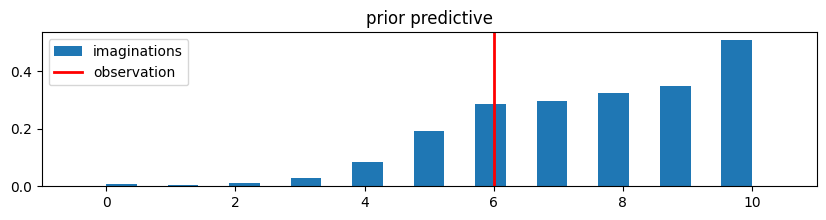

In [396]:
prior_predictive2 = numpyro.infer.Predictive(robot2, num_samples=10000)
prior_samples2 = prior_predictive2(jax.random.PRNGKey(int(time.time() * 1E6)))

plt.figure(figsize=(10, 2))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(prior_samples2[f"o{i}"][j] for i in range(len(OBSERVATIONS)))
          for j in range(len(prior_samples2['o0']))], 
          bins=len(OBSERVATIONS)*2+1, density=True,  label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("prior predictive")
plt.legend()
_=_

In [397]:
nuts_kernel2 = numpyro.infer.NUTS(robot2)
mcmc2 = numpyro.infer.MCMC(
    nuts_kernel2,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)

mcmc2.run(jax.random.PRNGKey(int(time.time() * 1E6)),
          obs=jax.numpy.array(OBSERVATIONS))

/var/folders/c1/rwhzmyd525n89mwj4hk9qn_c0000gn/T/ipykernel_22624/936896865.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc2 = numpyro.infer.MCMC(
sample: 100%|███████████████████████████| 5500/5500 [00:00<00:00, 14146.28it/s, 3 steps of size 7.52e-01. acc. prob=0.92]


### Posterior

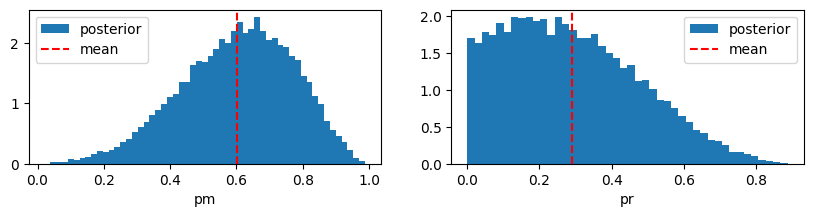

In [398]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
ax[0].set_xlabel("pm")
ax[0].hist(mcmc2.get_samples()['pm'], density=True, bins="auto", label="posterior")
ax[0].axvline(mcmc2.get_samples()['pm'].mean(), ls="dashed", color="red", label="mean")
ax[0].legend()
ax[1].set_xlabel("pr")
ax[1].hist(mcmc2.get_samples()['pr'], density=True, bins="auto", label="posterior")
ax[1].axvline(mcmc2.get_samples()['pr'].mean(), ls="dashed", color="red", label="mean")
ax[1].legend()
_=__=_

### Posterior predictive

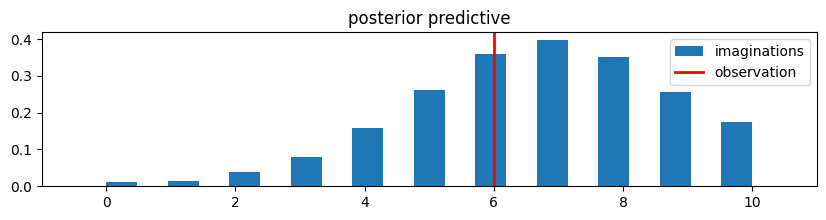

In [399]:
posterior_predictive2 = numpyro.infer.Predictive(robot2, posterior_samples=mcmc2.get_samples())
posterior_samples2 = posterior_predictive2(jax.random.PRNGKey(int(time.time() * 1E6)))

plt.figure(figsize=(10, 2))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(posterior_samples2[f"o{i}"][j] for i in range(len(OBSERVATIONS)))
          for j in range(len(posterior_samples2['o0']))], 
          bins=len(OBSERVATIONS)*2+1, density=True,  label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("posterior predictive")
plt.legend()
_=_

### Number of switches

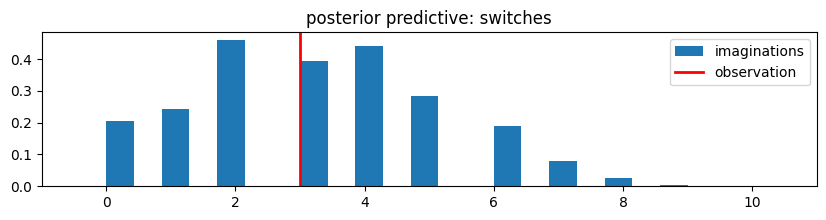

In [400]:
plt.figure(figsize=(10, 2))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([nswitches([posterior_samples2[f"o{i}"][j] for i in range(len(OBSERVATIONS))])
          for j in range(len(posterior_samples2['o0']))], 
          bins=len(OBSERVATIONS)*2+1, density=True,  label="imaginations")
plt.axvline(nswitches(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("posterior predictive: switches")
plt.legend()
_=_

In [401]:
p_value2 = sum(nswitches([posterior_samples2[f"o{i}"][j] for i in range(len(OBSERVATIONS))]) 
              >= nswitches(OBSERVATIONS)
              for j in range(len(posterior_samples2['o0'])))/len(posterior_samples2['o0'])
print(f"p_value2 = {p_value2:.3f}")

p_value2 = 0.609
